In [ ]:
!pip install yfinance

In [ ]:
!pip install --upgrade plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 38.1 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0


In [ ]:

!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

In [ ]:
ticker = 'AAPL'
stock_data = yf.download(ticker, start='2010-01-01', end='2023-01-01')
stock_data.to_csv('apple_stock_data.csv')
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.454506  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.465664  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.362820  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.351056  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.393282  447610800


In [ ]:


df = pd.read_csv('apple_stock_data.csv', index_col='Date', parse_dates=True)

full_range = pd.date_range(start=df.index.min(), end=df.index.max())

df_full = df.reindex(full_range)

df_full['Close'] = df_full['Close'].interpolate(method='linear')

df_full.index.name = 'Date'

df_full.to_csv('apple_stock_data_filled.csv')

print(df_full.isna().sum())

Open         1472
High         1472
Low          1472
Close           0
Adj Close    1472
Volume       1472
dtype: int64


In [ ]:
df=pd.read_csv('apple_stock_data_filled.csv')

df.head(90)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.454506,493729600.0
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.465664,601904800.0
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.362820,552160000.0
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.351056,477131200.0
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.393282,447610800.0
...,...,...,...,...,...,...,...
85,2010-03-30,8.450000,8.481429,8.366071,8.423214,7.113195,527310000.0
86,2010-03-31,8.410357,8.450357,8.373571,8.392857,7.087560,430659600.0
87,2010-04-01,8.478929,8.526071,8.312500,8.427500,7.116817,603145200.0
88,2010-04-02,NaN,NaN,NaN,8.450000,NaN,NaN


In [ ]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Close']].copy()
df.head(5)

,Close
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714


In [ ]:
df.describe()

,Close
count,4744.000000
mean,51.272566
std,47.304240
min,6.858929
25%,18.960001
50%,29.805417
75%,56.761874
max,182.009995


# **Testing if there is stationarity or not**

In [ ]:
def test_stationarity(timeseries):
    adf_test = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    for key, value in adf_test[4].items():
        print(f'Critial Values {key}: {value}')

test_stationarity(df.diff().diff().dropna())


ADF Statistic: -21.041547676161166
p-value: 0.0
Critial Values 1%: -3.4317391438401716
Critial Values 5%: -2.862153843045292
Critial Values 10%: -2.567096750826042


# **Analysing to determine the hyperParameter of P(AutoRegressor hyperparemeter) Q(Moving Average hyperParameter) D(the orderof differencing needed)**  

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

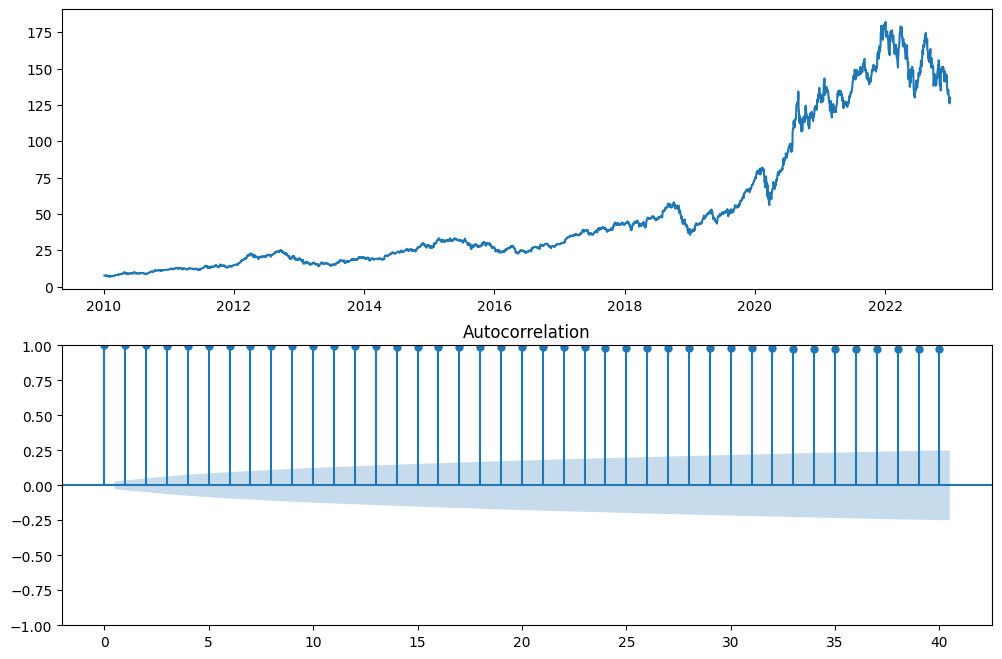

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
ax1.plot(df)
ax2 = fig.add_subplot(212)
fig = plot_acf(df.dropna(), lags=40, ax=ax2)

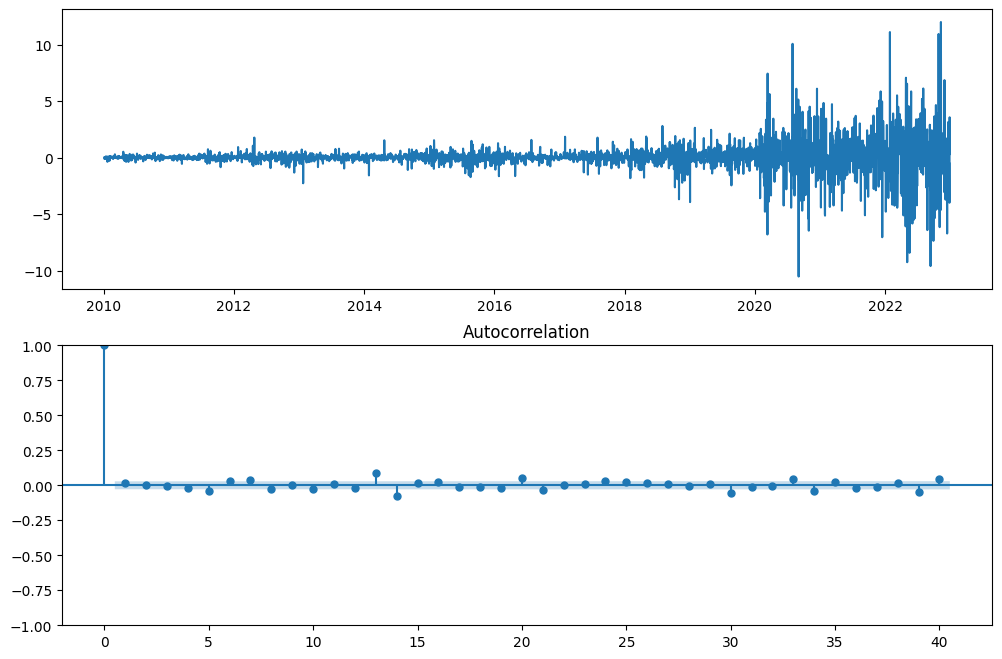

In [ ]:
diff = df.diff().dropna()

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
ax1.plot(diff)
ax2 = fig.add_subplot(212)
fig = plot_acf(diff.dropna(), lags=40, ax=ax2)

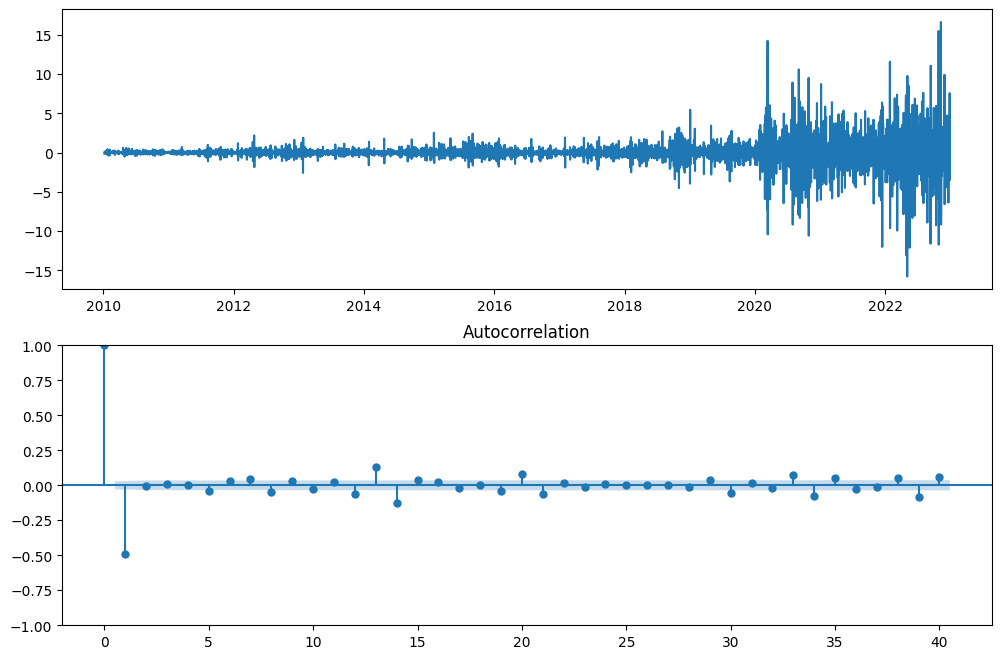

In [ ]:
diff = df.diff().diff().dropna()

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
ax1.plot(diff)
ax2 = fig.add_subplot(212)
fig = plot_acf(diff.dropna(), lags=40, ax=ax2)

Seeing the above we can detemine that one differencing is enought to convert to stationary and when there we diff twice we get one huge lag so we will have our **D value as 1**

In [ ]:
from pmdarima.arima.utils import ndiffs

In [ ]:
ndiffs(df, test='adf')

1

We also used inbuild function to detemine the number differncing required and we got the same result

**Now to determine P we will again  look at the acf plot**

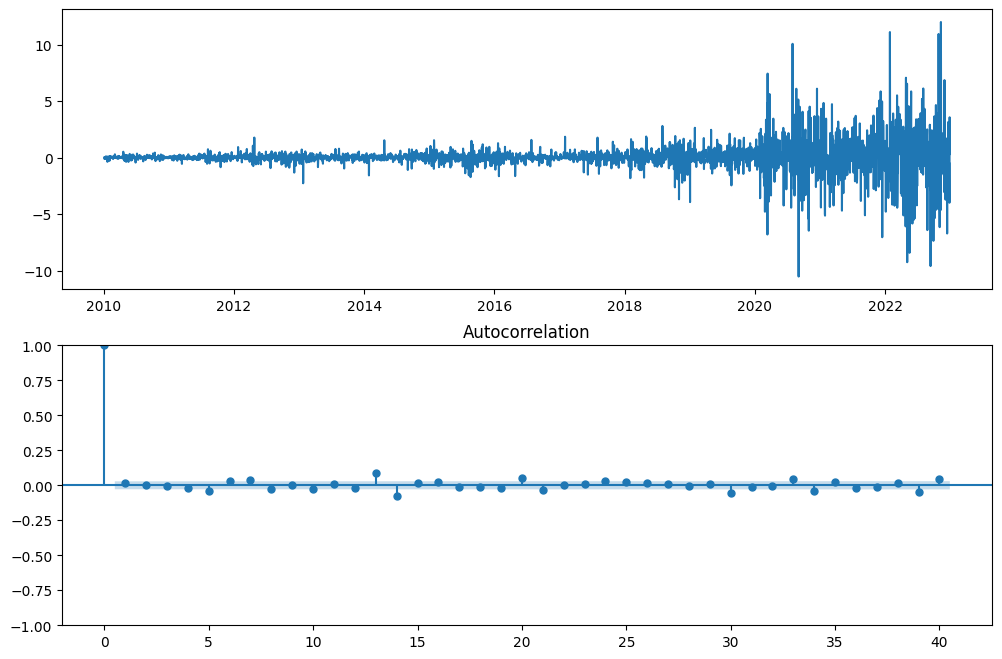

In [ ]:
diff = df.diff().dropna()

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
ax1.plot(diff)
ax2 = fig.add_subplot(212)
fig = plot_acf(diff.dropna(), lags=40, ax=ax2)

As you can see the closest lag here from the dense part is the 6th lag so by using n-1 formula we get the **p value to be 5**

**Now to determine Q we will again  look at the pacf plot**

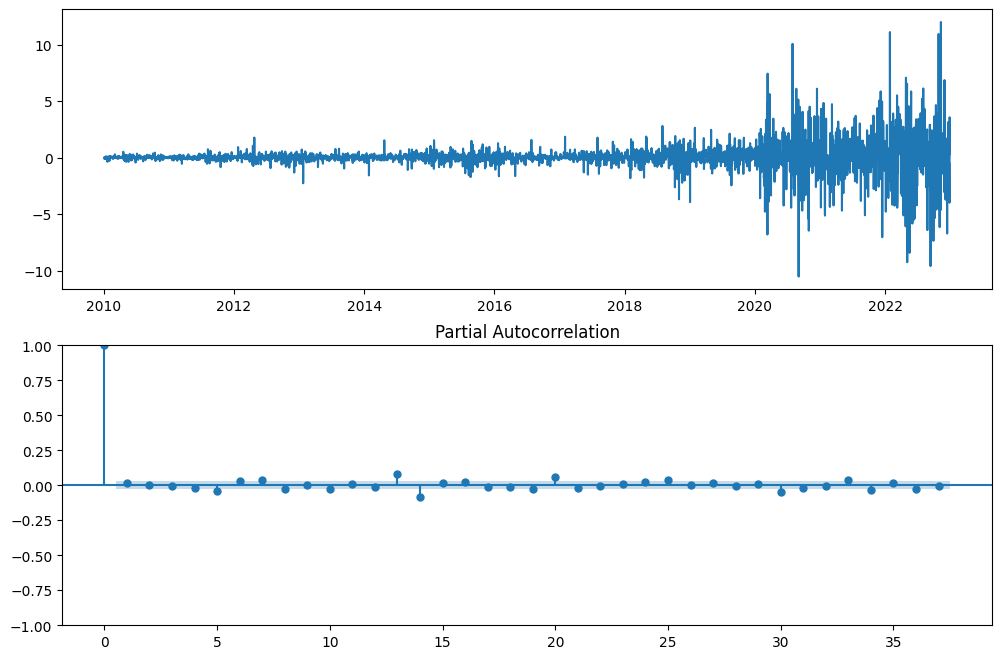

In [ ]:
diff = df.diff().dropna()

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
ax1.plot(diff)
ax2 = fig.add_subplot(212)
fig = plot_pacf(diff.dropna(), ax=ax2)

as you can see above the lag which is closest inside the dense area is 2st one so by using (n-1) formula **Q value is 1**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
model = ARIMA(df.dropna(), order=(5, 2, 1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5108
Model:                 ARIMA(5, 2, 1)   Log Likelihood               -7865.837
Date:                Mon, 09 Sep 2024   AIC                          15745.673
Time:                        10:47:43   BIC                          15791.441
Sample:                    01-04-2010   HQIC                         15761.697
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0296      0.006      4.713      0.000       0.017       0.042
ar.L2          0.0058      0.008      0.746      0.456      -0.009       0.021
ar.L3          0.0005      0.010      0.051      0.9

# **Ploting predicted values against the original**

<Axes: xlabel='Date'>

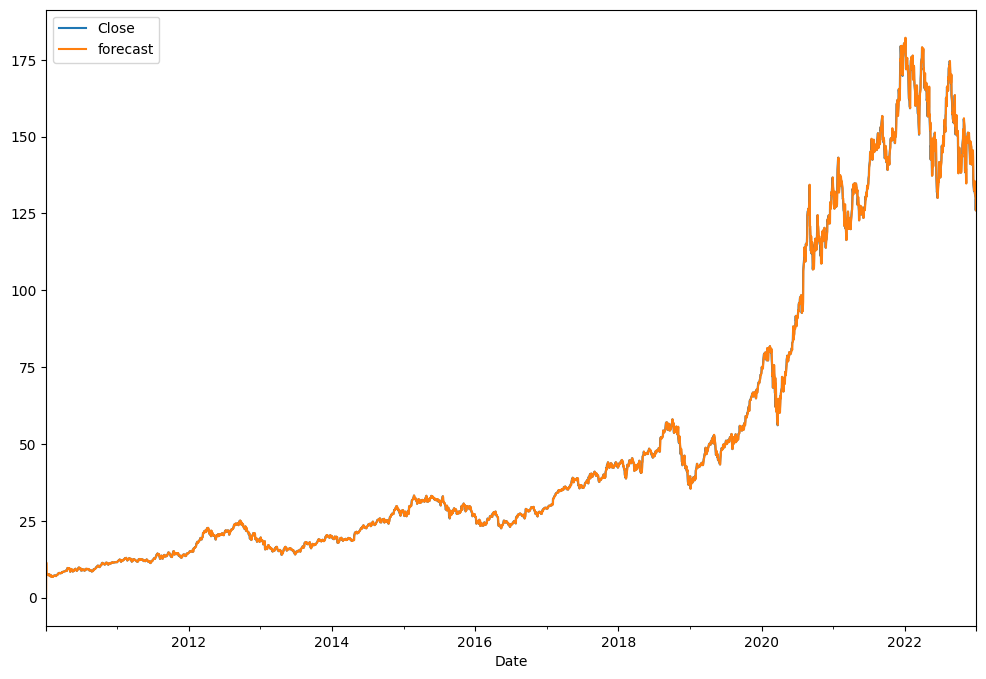

In [ ]:
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

fitted_values = model_fit.fittedvalues
df.index = pd.to_datetime(df.index)

df['forecast'] = model_fit.predict(start =0,end=(len(df.index)-1), typ='levels',dynamic=False)
df[['Close', 'forecast']].plot(figsize=(12, 8))





In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import numpy as np
df_test= df['Close']
predictions = df['forecast']

mse = mean_squared_error(df_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_test, predictions)
model_score = r2_score(df_test, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'model score (MS): {model_score}')


Mean Squared Error (MSE): 1.1747564075217973
Root Mean Squared Error (RMSE): 1.0838618027782865
Mean Absolute Error (MAE): 0.4966731258706585
model score (MS): 0.9994749033593352


In [ ]:
future_dates = [df.index[-1] + DateOffset(days=x) for x in range(1, 185)]

future_datest_df = pd.DataFrame(index=future_dates, columns=df.columns)

future_df = pd.concat([df, future_datest_df])
print(future_df)

               Close   forecast
2010-01-04  7.643214   0.000000
2010-01-05  7.656429  11.464821
2010-01-06  7.534643   7.669653
2010-01-07  7.520714   7.478699
2010-01-08  7.570714   7.480865
...              ...        ...
2023-06-28       NaN        NaN
2023-06-29       NaN        NaN
2023-06-30       NaN        NaN
2023-07-01       NaN        NaN
2023-07-02       NaN        NaN

[4928 rows x 2 columns]


<ipython-input-134-095d3389df63>:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df = pd.concat([df, future_datest_df])


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


               Close   forecast  future_forecast
2010-01-04  7.643214   0.000000              NaN
2010-01-05  7.656429  11.464821              NaN
2010-01-06  7.534643   7.669653              NaN
2010-01-07  7.520714   7.478699              NaN
2010-01-08  7.570714   7.480865              NaN
...              ...        ...              ...
2023-06-28       NaN        NaN       135.173958
2023-06-29       NaN        NaN       135.203688
2023-06-30       NaN        NaN       135.233417
2023-07-01       NaN        NaN       135.263147
2023-07-02       NaN        NaN       135.292877

[4928 rows x 3 columns]


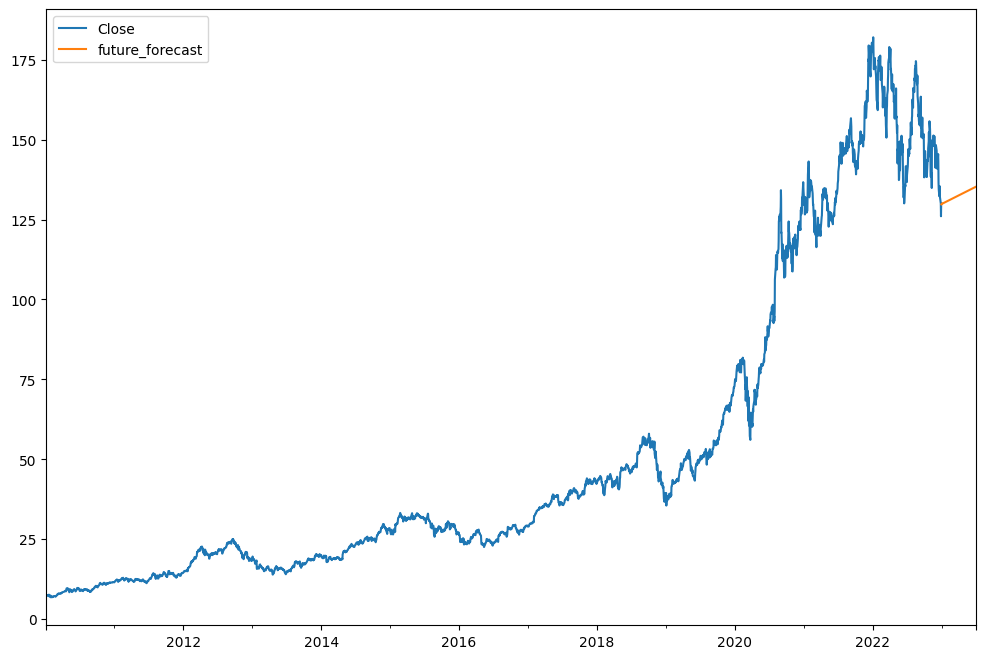

In [ ]:
future_df['future_forecast'] = model_fit.predict(start = df.index[-1],end=(len(future_df.index)-1), typ='levels',dynamic=True)
future_df[['Close', 'future_forecast']].plot(figsize=(12, 8))
print(future_df)

[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-25  218.929993  220.850006  214.619995  217.490005  217.238556   
2024-07-26  218.699997  219.490005  216.009995  217.960007  217.708008   
2024-07-29  216.960007  219.300003  215.750000  218.240005  217.987686   
2024-07-30  219.190002  220.330002  216.119995  218.800003  218.547043   
2024-07-31  221.440002  223.820007  220.630005  222.080002  221.823242   

              Volume  
Date                  
2024-07-25  51391200  
2024-07-26  41601300  
2024-07-29  36311800  
2024-07-30  41643800  
2024-07-31  50036300  
Open         1655
High         1655
Low          1655
Close           0
Adj Close    1655
Volume       1655
dtype: int64


<Axes: xlabel='Date'>

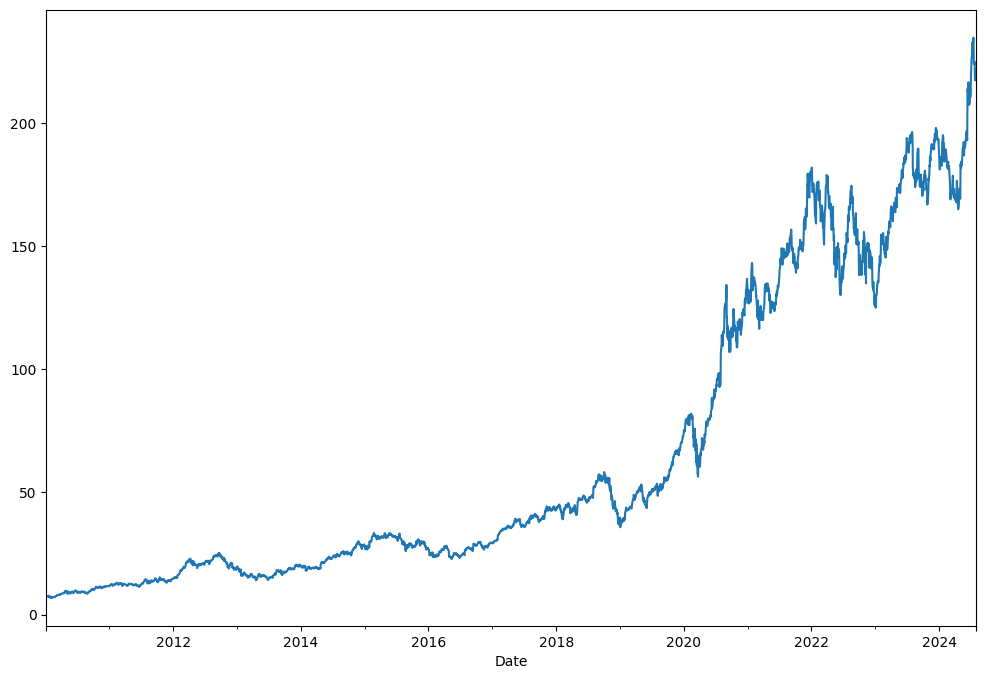

In [ ]:
stock_data = yf.download(ticker, start='2010-01-01', end='2024-08-01')
stock_data.to_csv('apple_stock_data.csv')
print(stock_data.tail())


df = pd.read_csv('apple_stock_data.csv', index_col='Date', parse_dates=True)

full_range = pd.date_range(start=df.index.min(), end=df.index.max())

df_full = df.reindex(full_range)

df_full['Close'] = df_full['Close'].interpolate(method='linear')

df_full.index.name = 'Date'

df_full.to_csv('apple_stock_data_filled.csv')

print(df_full.isna().sum())
df=pd.read_csv('apple_stock_data_filled.csv')
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Close']].copy()
df['Close'].plot(figsize=(12, 8))